In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Step 1. 데이터 다운로드

읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장
(https://github.com/songys/Chatbot_data)

In [2]:
chatbot_data = pd.read_csv('~/aiffel/transformer_chatbot/data/ChatbotData.csv')

In [3]:
chatbot_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
questions = chatbot_data['Q']
answers =chatbot_data['A']

In [5]:
print(questions[:5])
print(answers[:5])

0             12시 땡!
1        1지망 학교 떨어졌어
2       3박4일 놀러가고 싶다
3    3박4일 정도 놀러가고 싶다
4            PPL 심하네
Name: Q, dtype: object
0     하루가 또 가네요.
1      위로해 드립니다.
2    여행은 언제나 좋죠.
3    여행은 언제나 좋죠.
4     눈살이 찌푸려지죠.
Name: A, dtype: object


## Step 2. 데이터 정제
아래 조건을 만족하는 preprocess_sentence() 함수를 구현하세요.

1. 영문자의 경우, 모두 소문자로 변환
2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거

In [6]:
def preprocess_sentence(sentence):
    # 대문자를 소문자로 변환
    sentence = sentence.lower()
    # 두 개 이상의 공백을 하나로 변경
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거합니다.
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", sentence)
    # 문자열 양끝 공백 제거
    sentence = sentence.strip()
    return sentence

## Step 3. 데이터 토큰화
토큰화에는 KoNLPy의 mecab 클래스를 사용

아래 조건을 만족하는 build_corpus() 함수를 구현

1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.
3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
5. 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!
구현한 함수를 활용하여 questions 와 answers 를 각각 que_corpus , ans_corpus 에 토큰화하여 저장.

In [7]:
from konlpy.tag import Mecab

def build_corpus(questions, answers, max_len=100000):
    questions = list(map(preprocess_sentence, questions))
    answers = list(map(preprocess_sentence, answers))
    
    mecab = Mecab()
    que_corpus = [" ".join(mecab.morphs(q)) for q in questions]
    ans_corpus = [" ".join(mecab.morphs(a)) for a in answers]
    
    que_set = set()
    ans_set = set()
    new_que_corpus = []
    new_ans_corpus = []
    
    for que, ans in zip(que_corpus, ans_corpus):
        if (len(que.split()) > max_len) or (len(ans.split()) > max_len):
            continue
        if (que not in que_set) and (ans not in ans_set):
            new_que_corpus.append(que)
            new_ans_corpus.append(ans)
        que_set.add(que)
        ans_set.add(ans)
    
    return new_que_corpus, new_ans_corpus

In [8]:
que_corpus, ans_corpus = build_corpus(questions, answers)

In [9]:
print(que_corpus[:5])
print(ans_corpus[:5])

['시 땡 !', '지망 학교 떨어졌 어', '박 일 놀 러 가 고 싶 다', 'ppl 심하 네', 'sd 카드 망가졌 어']
['하루 가 또 가 네요 .', '위로 해 드립니다 .', '여행 은 언제나 좋 죠 .', '눈살 이 찌푸려 지 죠 .', '다시 새로 사 는 게 마음 편해요 .']


In [10]:
import statistics

def length_statistics_without_spaces(strings):
    if not strings:
        return 0, 0, 0  # 빈 리스트의 경우 평균, 표준편차, 최대 길이는 0으로 정의

    # 각 문자열의 길이(공백 제외)를 리스트로 저장
    lengths_without_spaces = [len(s.replace(" ", "")) for s in strings]

    # 평균, 표준편차, 최대 길이 계산
    average_length = statistics.mean(lengths_without_spaces)
    std_dev = statistics.stdev(lengths_without_spaces)
    max_length = max(lengths_without_spaces)

    return average_length, std_dev, max_length

In [11]:
average_length_que, std_dev_que, max_len_que=length_statistics_without_spaces(que_corpus)
# 결과 출력
print("Average Length:", average_length_que)
print("Standard Deviation of Lengths:", std_dev_que)
print("Maximum Length:", max_len_que)

Average Length: 10.896962555642839
Standard Deviation of Lengths: 5.052090962074841
Maximum Length: 42


In [12]:
average_length_ans, std_dev_ans, max_len_ans=length_statistics_without_spaces(ans_corpus)
# 결과 출력
print("Average Length:", average_length_ans)
print("Standard Deviation of Lengths:", std_dev_ans)
print("Maximum Length:", max_len_ans)

Average Length: 12.796412673474732
Standard Deviation of Lengths: 5.029680425074284
Maximum Length: 57


In [13]:
max_len = 20
que_corpus, ans_corpus = build_corpus(questions, answers, max_len)

In [14]:
len(que_corpus), len(ans_corpus)

(7528, 7528)

In [15]:
que_corpus[1], ans_corpus[1]

('지망 학교 떨어졌 어', '위로 해 드립니다 .')

## Step 4. Augmentation

우리에게 주어진 데이터는 1만 개가량으로 적은 편에 속합니다. 이럴 때에 사용할 수 있는 테크닉을 배웠으니 활용해 봐야겠죠? Lexical Substitution을 실제로 적용해 보도록 하겠습니다.

아래 링크를 참고하여 한국어로 사전 훈련된 Embedding 모델을 다운로드합니다. Korean (w) 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 Korean (w)를 찾아 다운로드하고, ko.bin 파일을 얻으세요!

[Kyubyong/wordvectors](https://github.com/Kyubyong/wordvectors)

다운로드한 모델을 활용해 데이터를 Augmentation 하세요! 앞서 정의한 lexical_sub() 함수를 참고하면 도움이 많이 될 겁니다.

Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록, 이후엔 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.

In [17]:
# 한국어 word2vec이 최신버전에서 Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' 오류가 있음.
!pip install --upgrade gensim==3.8.3

In [16]:
import gensim
# print(gensim.__version__)
wordvec = gensim.models.Word2Vec.load('~/aiffel/transformer_chatbot/data/ko.bin')

In [17]:
wordvec.most_similar("이름")

/tmp/ipykernel_195/3017808742.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  wordvec.most_similar("이름")


[('별칭', 0.782331109046936),
 ('별명', 0.7666158676147461),
 ('명칭', 0.7516838312149048),
 ('애칭', 0.708103597164154),
 ('닉네임', 0.6756349205970764),
 ('제목', 0.6683703660964966),
 ('필명', 0.6622928380966187),
 ('예명', 0.6547982096672058),
 ('가명', 0.6531900763511658),
 ('호칭', 0.6482669115066528)]

In [18]:
def lexical_sub(sample_sentence, wordvec):
    sample_tokens = sample_sentence.split()
    selected_tok = random.choice(sample_tokens)
    result = ""
    for tok in sample_tokens:
        if tok is selected_tok and tok not in "?.!,":
            try:
                result += wordvec.most_similar(tok)[0][0] + " "
            except:
                result += tok + " "

        else:
            result += tok + " "
    return result.strip()

In [19]:
print(que_corpus[3], lexical_sub(que_corpus[3], wordvec))
print(que_corpus[5], lexical_sub(que_corpus[5], wordvec))

ppl 심하 네 ppl 심하 네
sns 맞 팔 왜 안 하 지 ㅠㅠ sns 맞 팔 왜 못가 하 지 ㅠㅠ


/tmp/ipykernel_195/3847131956.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  result += wordvec.most_similar(tok)[0][0] + " "


In [20]:
wordvec.most_similar("사람")

/tmp/ipykernel_195/3748499257.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  wordvec.most_similar("사람")


[('젊은이', 0.6494427919387817),
 ('여인', 0.6287257671356201),
 ('백성', 0.6063710451126099),
 ('포졸', 0.6043275594711304),
 ('죄인', 0.5960500836372375),
 ('선비', 0.5868039131164551),
 ('부녀자', 0.5654411315917969),
 ('죄수', 0.5639811754226685),
 ('구경꾼', 0.5620019435882568),
 ('손님', 0.5589558482170105)]

In [21]:
ans_corpus_aug = list(map(lambda s: lexical_sub(s, wordvec), ans_corpus))
que_corpus_aug = list(map(lambda s: lexical_sub(s, wordvec), que_corpus))

/tmp/ipykernel_195/3847131956.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  result += wordvec.most_similar(tok)[0][0] + " "


## Step 5. 데이터 벡터화

타겟 데이터인 ans_corpus 에 <start> 토큰과 <end> 토큰이 추가되지 않은 상태이니 이를 먼저 해결한 후 벡터화를 진행합니다. 우리가 구축한 ans_corpus 는 list 형태이기 때문에 아주 쉽게 이를 해결할 수 있답니다!
    
```
sample_data = ["12", "시", "땡", "!"]
print(["<start>"] + sample_data + ["<end>"])
```
    
1. 위 소스를 참고하여 타겟 데이터 전체에 <start> 토큰과 <end> 토큰을 추가해 주세요!

챗봇 훈련 데이터의 가장 큰 특징 중 하나라고 하자면 바로 소스 데이터와 타겟 데이터가 같은 언어를 사용한다는 것이겠죠. 앞서 배운 것처럼 이는 Embedding 층을 공유했을 때 많은 이점을 얻을 수 있습니다.

2. 특수 토큰을 더함으로써 ans_corpus 또한 완성이 되었으니, que_corpus 와 결합하여 전체 데이터에 대한 단어 사전을 구축하고 벡터화하여 enc_train 과 dec_train 을 얻으세요!

In [22]:
ans_corpus = list(map(lambda s: "<start> " + s + " <end>", ans_corpus))
ans_corpus_aug = list(map(lambda s: "<start> " + s + " <end>", ans_corpus_aug))

In [23]:
# 데이터 증강
enc_corpus = que_corpus + que_corpus_aug + que_corpus
dec_corpus = ans_corpus + ans_corpus + ans_corpus_aug

In [25]:
len(enc_corpus), len(dec_corpus)

(22584, 22584)

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(enc_corpus + dec_corpus)
len(tokenizer.word_index)

7063

In [27]:
VOCAB_SIZE = 6000 # 거의 대부분 사용
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<UNK>", filters="")
tokenizer.fit_on_texts(enc_corpus + dec_corpus)

In [28]:
from keras.preprocessing.sequence import pad_sequences
enc_train = tokenizer.texts_to_sequences(enc_corpus)
enc_train = pad_sequences(enc_train, padding='post', maxlen=max_len)

In [29]:
dec_train = tokenizer.texts_to_sequences(dec_corpus)
dec_train = pad_sequences(dec_train, padding='post', maxlen=max_len+1)

In [30]:
enc_corpus[1], dec_corpus[1], enc_train[1], dec_train[1]

('지망 학교 떨어졌 어',
 '<start> 위로 해 드립니다 . <end>',
 array([3785,  640, 1062,   13,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([   3,  638,   17, 1489,    2,    4,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       dtype=int32))

## Step 6. 훈련하기

앞서 번역 모델을 훈련하며 정의한 Transformer 를 그대로 사용하시면 됩니다! 대신 데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 모델을 훈련하고 아래 예문에 대한 답변을 생성하세요! 가장 멋진 답변과 모델의 하이퍼파라미터를 제출하시면 됩니다.


## 모델 구현

In [31]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    sinusoid_table = np.array([[pos_i / np.power(10000, 2 * (d_j // 2) / np.float32(d_model)) for d_j in range(d_model)] for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [32]:
# Mask  생성하기
def generate_padding_mask(seq):
    # 시퀀스에서 각 위치의 값이 0인지 확인
    mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # 차원 추가하여 마스크의 형태를 모델에 맞게 조정
    # 예: (batch_size, 1, 1, sequence_length) 
    return mask[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    # mask 부분에 대해서 구하려면 1에서 빼줌
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    # dec_mask is masked attention
    lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(lookahead_mask, padding_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [33]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        # for multi head split
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
    
        # for multi head combine
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        # scaled_QK = Q K^t / sqrt(d_k) 
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_QK = QK / tf.math.sqrt(d_k) # shape: (seq, seq)

        if mask is not None:
            # softmax를 취하기 때문에 -무한대를 주면 해당 값이 0이 됨.
            scaled_QK += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_QK, axis=-1)
        out = tf.matmul(attentions, V)
        
        return out, attentions
        
    def split_heads(self, x):
        # (batch_size, seq, d_model) -> (batch_size, seq, num_heads, depth)
        split_x = tf.reshape(x, (x.shape[0], -1, self.num_heads, self.depth))
        # (batch_size, seq, num_heads, depth) ->  (batch_size, num_heads, seq, depth)
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        return split_x

    def combine_heads(self, x):
        # (batch_size, num_heads, seq, depth) -> (batch_size, seq, num_heads, depth)
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        # (batch_size, seq, num_heads, depth) -> (batch_size, seq, d_model)
        combined_x = tf.reshape(combined_x, (combined_x.shape[0], -1, self.d_model))
        return combined_x

    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        # split head
        Q_splits = self.split_heads(WQ)
        K_splits = self.split_heads(WK)
        V_splits = self.split_heads(WV)

        # attention mechanism
        out, attention_weights = self.scaled_dot_product_attention(Q_splits, K_splits, V_splits, mask)
        
        # combine head
        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [34]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [35]:
# Encoder 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        ## pre-LN 적용
        # Multi-Head Attention
        identity = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += identity
        
        # Position-Wise Feed Forward Network
        identity = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += identity
        
        return out, enc_attn

In [36]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.dec_enc_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, dec_mask):
        # Masked Multi-Head Attention
        identity = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, dec_mask)
        out = self.do(out)
        out += identity
        
        # Multi-Head Attention
        identity = out
        out = self.norm_2(x)
        out, dec_enc_attn = self.dec_enc_attn(out, enc_out, enc_out, dec_enc_mask)
        out = self.do(out)
        out += identity
        
        # Position-Wise Feed Forward Network
        identity = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += identity

        return out, dec_attn, dec_enc_attn

In [37]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
        enc_attns = []
        for enc_layer in self.enc_layers:
            out, enc_attn = enc_layer(out, mask)
            enc_attns.append(enc_attn)
        return out, enc_attns

In [38]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, dec_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, dec_enc_mask, dec_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [39]:
# Transformer 전체 모델 조립
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared_fc: 
            out *= tf.math.sqrt(self.d_model)

        # pos_encoding (max_seq_len, max_seq_len) vs embedding vector (batch_size, seq_len, d_model)
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [40]:
# 모델 인스턴스 생성
d_model = 256
VOCAB_SIZE = len(tokenizer.word_index)
transformer = Transformer(
    n_layers=2,
    d_model=d_model,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=100,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

In [41]:
# Learning Rate Scheduler
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [42]:
# Learning Rate & Optimizer
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [43]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [44]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [45]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).batch(batch_size=BATCH_SIZE)

In [46]:
def evaluate(sentence, model, tokenizer): 
    # start, end = 3, 4
    sentence = preprocess_sentence(sentence)

    tokens = tokenizer.texts_to_sequences([sentence])

    _input = tf.keras.preprocessing.sequence.pad_sequences(tokens,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([3], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if 4 == predicted_id:
            result = tokenizer.sequences_to_texts([ids])
            return result[0], enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tokenizer.sequences_to_texts([ids])

    return result[0], enc_attns, dec_attns, dec_enc_attns

In [47]:
def generate_answer():
    question_list = ['지루하다, 놀러가고 싶어.', '오늘 일찍 일어났더니 피곤하다.', '간만에 여자친구랑 데이트 하기로 했어.', '집에 있는다는 소리야.']

    for question in question_list:
        print(f"Q: {question}\nA: {evaluate(question, transformer, tokenizer)[0]}\n")
generate_answer()

Q: 지루하다, 놀러가고 싶어.
A: 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히

Q: 오늘 일찍 일어났더니 피곤하다.
A: 허기지 허기지 허기지 허기지 허기지 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 허기지 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인 본인

Q: 집에 있는다는 소리야.
A: 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히 가만히



In [49]:
EPOCHS = 50
for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for src, tgt in train_dataset:
        loss, enc_attns, dec_attns, dec_enc_attnss = train_step(src, tgt, transformer, optimizer)
        total_loss += loss
        tqdm_bar.update(1)
    print(f"epoch {epoch + 1} train loss: {(total_loss / dataset_count):.4f}")
    generate_answer()
    tqdm_bar.close()

  0%|          | 0/353 [00:00<?, ?it/s]

epoch 1 train loss: 0.0783
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 힘들 거 라 생각 해요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 휴식 이 필요 하 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 2 train loss: 0.0777
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 어떤 선택 이 든지 였 길 바라 오자키 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 잠깐 눈 이 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 3 train loss: 0.0771
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 힘들 었 을 거 라 생각 해요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 잠깐 눈 을 <UNK> 하 기 전 에 <UNK> 그러 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 4 train loss: 0.0746
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 힘들 었 을 거 라 생각 해요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 잠깐 눈 이 길래 좋 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 5 train loss: 0.0791
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 슬픔 그러 었 길 바랄게요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 잠깐 핸드폰 도 괜찮 아요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 6 train loss: 0.0792
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 많이 실망 때때 거 라 생각 해요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 잠깐 핸드폰 도 괜찮 아요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 7 train loss: 0.0788
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 힘들 결정 이 었 겠 는데요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 잠깐 눈 을 <UNK> 말 해 보 세요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 8 train loss: 0.0756
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 슬픔 그러 었 길 바랄게요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 야경 이 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 9 train loss: 0.0742
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 힘들 싶 지만 잘 정도 맛있 는 것 같 아요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: <UNK> 좋 은 시간 이 필요 하 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 10 train loss: 0.0648
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 마음 이 부유층 어 줄게요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: <UNK> 도 좋 은 이곳 에 가 보 세요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 11 train loss: 0.0637
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 힘들 결정 이 었 을 거 라고 생각 해요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 잠깐 눈 을 붙여 살펴보 세요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 12 train loss: 0.0615
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 않 는 어야 할 자신 이 아프 네요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 힘내 ㅂ시오 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 잠깐 눈 이 기 도 하 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 않 는 어야 할 자신 이 아프 네요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 13 train loss: 0.0659
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 않 는 연습 을 해 보 세요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 많이 아프 었 길 바랄게요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 잠시 쉬 <UNK> 도 괜찮 아요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 않 는 연습 을 해 보 세요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 14 train loss: 0.0681
Q: 지루하다, 놀러가고 싶어.
A: 더 행복 해 지 고자 하 나 봐요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 자신 를 조금 씩 를 하 나 봐요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: <UNK> 이 없 는 거 죠 .

Q: 집에 있는다는 소리야.
A: 더 행복 해 지 고자 하 나 봐요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 15 train loss: 0.0732
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 지금 그러 에요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: <UNK> 이 없 는 <UNK> 이 에요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 16 train loss: 0.0633
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 관리 었 을 괜찮 아요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 상황 그러 궁금 하 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 17 train loss: 0.0675
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 만큼 수십 동안 고생 했 는데요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 휴식 이 불필요 하 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 18 train loss: 0.0648
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 동안 고생 했 는데요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 좋 은 동작 이 되 지요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 19 train loss: 0.0794
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 아요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 좋 은 의미 는 이 휴식 도 필요 해요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 20 train loss: 0.0734
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 내일 은 허전 할 거 들 을 생각 해요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 좋 은 타이밍 이 곁 에 있 지 않 은 의미 봐요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 21 train loss: 0.0654
Q: 지루하다, 놀러가고 싶어.
A: 자신 으로 향하 지 않 길 바랄게요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은데 힘내 지 않 아도 돼요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 휴식 이 필요 할 필요 해요 .

Q: 집에 있는다는 소리야.
A: 자신 으로 향하 지 않 길 바랄게요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 22 train loss: 0.0669
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 관리 하 는 방법 들 아요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 좋 은 계절 이 에요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 23 train loss: 0.0753
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 마음 이 에요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 휴식 이 필요 한가요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 24 train loss: 0.0636
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 쉬 를 거 라 생각 해요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 좋 은 분간 이 불필요 하 지요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 25 train loss: 0.0696
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 쉬 가 점점 연속 이 에요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 좋 은 만남 이 어 잊 는 것 같 아요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 26 train loss: 0.0737
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 흘러가 는 슬픔 의 선택 은 아니 에요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 좋 은 설정 이 에요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 27 train loss: 0.0676
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 불필요 하 았 길 바랄게요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 휴식 이 불필요 하 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 28 train loss: 0.0617
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 언젠간 당신 을 <UNK> 다가 천천히 깃털 어 보 세요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 서로 에게 괜찮 아요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 29 train loss: 0.0610
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 언젠간 당신 을 는데요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 좋 은 사람 이 찾아오 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 30 train loss: 0.0558
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 언젠간 당신 을 좋아해 하 길 바랄게요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 때쯤 는 으로서 는 건과 없 을 거 예요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 31 train loss: 0.0516
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 언젠간 당신 을 좋아해 하 길 바랄게요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 어떤 일 이 불필요 할 수 없 어요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 32 train loss: 0.0451
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 마음 이 허전 시키 시 군요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 좋 은 슬픔 받 고 있 는 거 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 33 train loss: 0.0428
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 언젠간 닥쳐올 순간 이 었 을 것 같 아요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 좋 은 슬픔 도 당신 이 부러워요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 34 train loss: 0.0445
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 변동 의 괴로움 에서 쉬 세요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 잠시 쉬 어가 도 괜찮 은데요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 35 train loss: 0.0396
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 동안 고생 했 는데요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 떨 고 있 기 전 에 는 것 도 좋 아요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 36 train loss: 0.0382
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 추억 만 의 선택 에서 멀 에요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 떨 이 없었 는 거 같 아요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 37 train loss: 0.0365
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 항상 힘들 어요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 좋 은 경험 이 없 을 거 예요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 38 train loss: 0.0345
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 쉬 였 길 바랄게요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 휴식 그러 찾아오 길 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 39 train loss: 0.0335
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 쉬 었 다가 가 세요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 휴식 그러 찾아오 구불구불 바랄게요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 40 train loss: 0.0338
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 변동 의 슬픔 이 었 나요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 좋 은 설정 이 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 41 train loss: 0.0383
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 변동 의 슬픔 에 증상 그러 에요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 그 애 에 는 귀 를 기울여 봐요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 42 train loss: 0.0368
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 변동 의 선택 이 었 을 거 라 생각 해요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 발르 네요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 43 train loss: 0.0409
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 그냥 뒹굴 뒹글 같이 이런 거 예요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 이라고 하 지 도 않 고 사랑 은 젊은이 이 에요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 44 train loss: 0.0384
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 그냥 뒹굴 뒹글 같이 변동 해 보 세요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 그 사람 도 당신 이 아프 네요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 45 train loss: 0.0397
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 언젠간 친분 이 었 나 봐요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 그 사람 도 당신 의 불필요 함 이 필요 해요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 46 train loss: 0.0407
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 언젠간 인연 이 였 나 봐요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 그 사람 도 당신 의 인연 이 필요 해요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 47 train loss: 0.0397
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 언젠간 잊혀질 거 라 생각 해요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 그 사람 의 능력 이 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 48 train loss: 0.0352
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 언젠간 잊혀질 거 라 생각 해요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 성공 시키 길 바랄게요 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 49 train loss: 0.0349
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 언젠간 친분 이 었 길 바랄게요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 발르 는 편 이 휴식 이 필요 하 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



  0%|          | 0/353 [00:00<?, ?it/s]

epoch 50 train loss: 0.0377
Q: 지루하다, 놀러가고 싶어.
A: 아프 꼼짝 말 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 내일 은 같이 아래 들 을 거 예요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 발르 는 게 가장 중요 하 죠 .

Q: 집에 있는다는 소리야.
A: 아프 꼼짝 말 아요 .



# 회고
epoch을 처음에 30번 두번째 때 50번  총 80번 돌려봤는데   
두번째 21번이 그나마 잘나온거 같다  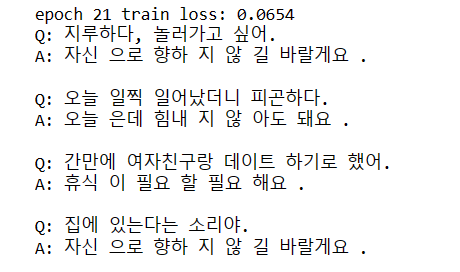
loss는 진행하는동안 계속 감소하는것을 확인하였다. Lexical Substitution 데이터 증강이 문제였을까 아니면 전처리 문제였을까 다시한번 생각해서 해보아야겠다. 
또 첫번째와 네번째 질문에서 자꾸 아프 꼼짝 말 아요. 라는 같은 결과값이 나오는데 이것에 대한 문제점은 아직 잘 모르겠다... 
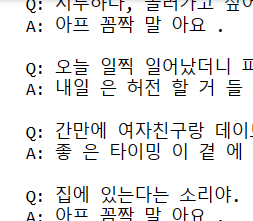
